In [32]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

## RMSD Calculation

In [2]:
#Read all the trajectories
colpk_pyc= mda.Universe('colpk_py/sys_prod/start.pdb', 'colpk_py/sys_prod/prod_colpk_pyc_complex_compact_compact.xtc')


/usr/local/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)


  0%|          | 0/5001 [00:00<?, ?it/s]

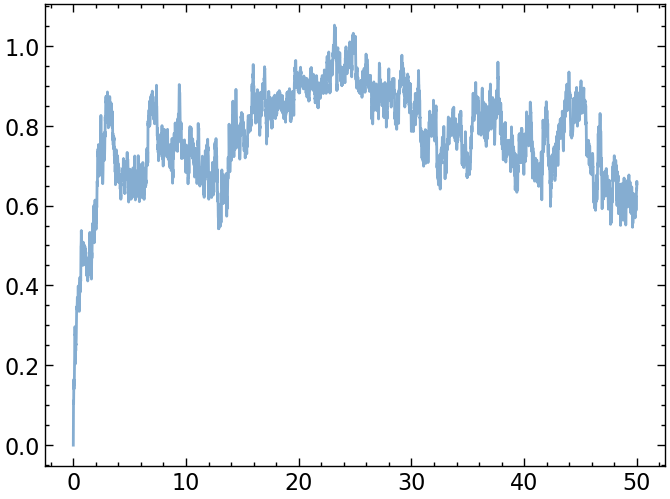

In [3]:
from MDAnalysis.analysis import rms

R = rms.RMSD(colpk_pyc,  # universe to align
    colpk_pyc,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c = R.results.rmsd[:,1]
rmsd_c = R.results.rmsd[:,2]
plt.plot(times_c/1000, rmsd_c/10, alpha=0.5)

## Radius of Gyration Calculation

  0%|          | 0/5001 [00:00<?, ?it/s]

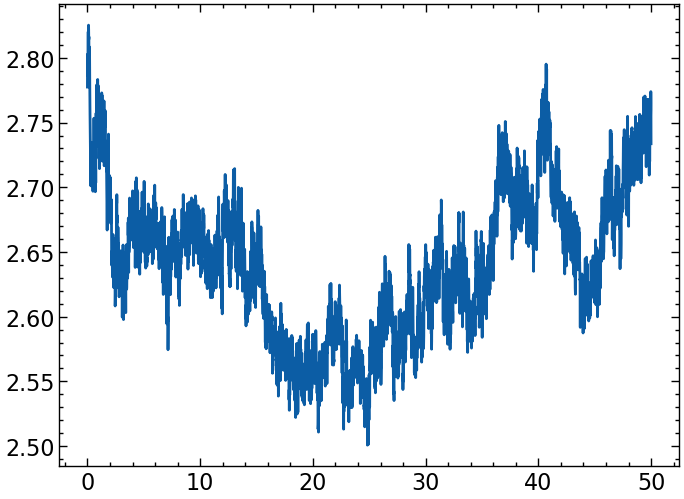

In [4]:
from tqdm.notebook import tqdm
group = colpk_pyc.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(colpk_pyc.trajectory):
	Frame.append(ts.frame)
	times.append(colpk_pyc.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T
plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10)

## RMSF Calculation

Between protein backbone and Carbon alphas.

  0%|          | 0/5001 [00:00<?, ?it/s]

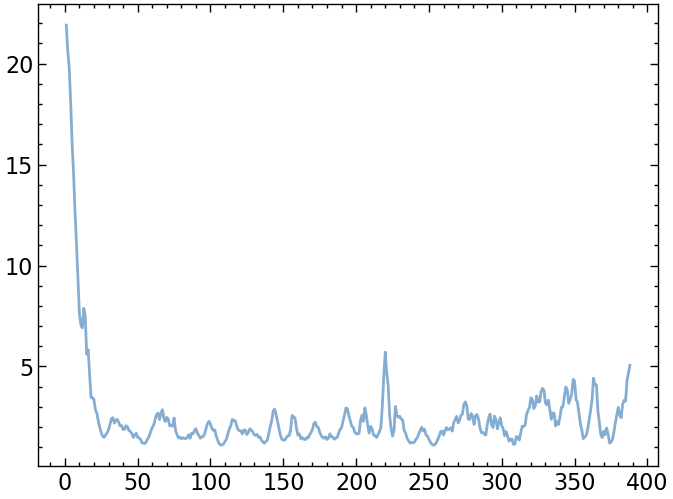

In [5]:
c_alphas_c = colpk_pyc.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run(verbose=True)
plt.plot(c_alphas_c.resids, R_c.results.rmsf, alpha=0.5)

### Observations

Rapid changes in radius of gyration, together with high RMSF in the first few residues of the protein suggest conformational changes in the tail end of the chain. Might need `DSSP` for further analysis.

## H-bond analysis:

**Note:** As of today (20241222), the latest version of MDAnalysis (2.8) cannot read binary topology files (the ones with the `.tpr` extension) created by gromacs version 2024.4. Binary topology data is necessary for hydrogen bond analysis in `MDAnalysis` for some reason, so I am trying `MDTraj` instead.


In `MDTraj`, the Baker-Hubbard Hydrogen Bond Identification can be used, where the hydrogen bond is said to have formed if:

1. The angle $\theta_{dha}>2\pi/3$, *i.e.*, $120$ degrees, and
2. The distance $r_{ha}<0.25\;nm$. 
   
Here, $d$ means 'donor', 'h' means 'hydrogen', and 'a' means acceptor.
The donors considered by this method are NH and OH, and the acceptors considered are O and N.

Do not load the whole trajectory, as it will take up too much memory. Unlike `MDAnalysis`, `MDTraj` doesn't do lazy loads from disk, but fully operates in memory. This makes it faster, but memory-intensive.

So, we choose a 'stride' of, say, $60$ frames, and have `MDTraj` load every $60^{th}$ frame of the trajectory, then run the baker-hubbard algorithm.

In [17]:
stride = 3
total_frames = 5000
total_time_ns = 50

timestep  = (stride/total_frames) * total_time_ns

nframes = int(np.ceil(total_frames/stride))

timestep, nframes

(0.03, 1667)

In [18]:
%%time
import numpy as np
import mdtraj as md


topfile='colpk_py/sys_prod/start.pdb'
xtcfile='colpk_py/sys_prod/prod_colpk_pyc_complex_compact_compact.xtc'

full_traj = md.load_xtc(xtcfile, stride=stride, top=topfile)
pyc_atoms = full_traj.topology.select('resname PYC')
hbonds = md.baker_hubbard(full_traj, periodic=False, freq=0.01)
label = lambda hbond : '%s - %s ... %s' % ( full_traj.topology.atom(hbond[0]),\
                                            full_traj.topology.atom(hbond[1]),\
                                            full_traj.topology.atom(hbond[2]))
pyc_hbonds = []
for hbond in hbonds:
    d,h,a = hbond
    if d in pyc_atoms or a in pyc_atoms:
        pyc_hbonds.append(hbond)
        print(label(hbond))

pyc_hbonds = np.array(pyc_hbonds)

CPU times: user 1min 43s, sys: 19.6 s, total: 2min 3s
Wall time: 2min 32s


In [19]:
pyc_hbonds

array([], dtype=float64)

In [21]:
np.unique(hbonds, axis=0).shape

(1063, 3)

So, according to `MDTraj` Baker-Hubbard hbond detector, there are **NO** hydrogen bonds betweek protein and  that form at more than a frequency of `freq=` $0.01$ in the trajectory frames. This is consistent with the video from `VMD.`

**However**, a whole bunch of hbonds are being detected within the protein ($1063$, to be exact). These may need further analysis.

## Plots

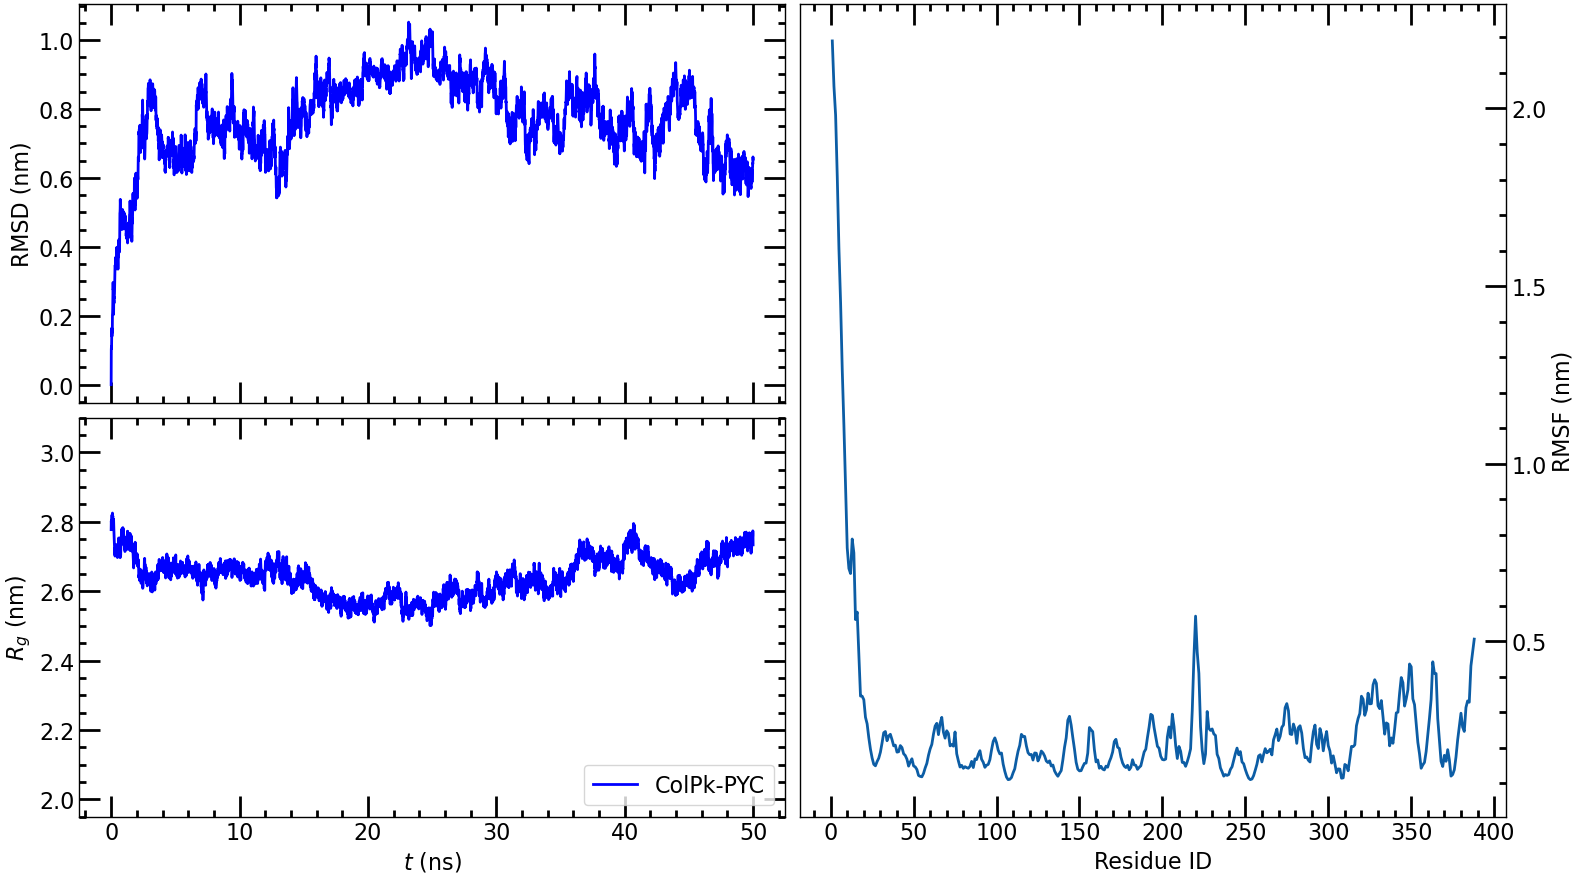

In [59]:
plt.style.use(['science','notebook'])
fig, axs = plt.subplots(2,2,figsize=(16,9), sharex=True, tight_layout=True)

ax_rmsd = axs[0,0]
ax_rmsd.set_ylabel(r'RMSD (nm)');


ax_rmsd.plot(times_c/1000, rmsd_c/10, label="ColPk-PYC", 
        color='blue')


ax_rg = axs[1,0]

ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, 
        label="ColPk-PYC", color='blue')
ax_rg.set_ylabel(r'$R_g$ (nm)')
ax_rg.set_xlabel(r'$t$ (ns)');
ax_rg.set_ylim(1.95,3.1)

# Remove the second row, second column subplot 
fig.delaxes(axs[1, 1]) # Merge the first row, second column subplot to cover the two positions 
axs[0, 1].remove() 
ax_rmsf = fig.add_subplot(2, 2, (2, 4))
ax_rmsf.plot(c_alphas_c.resids, R_c.results.rmsf/10)
ax_rmsf.set_xlabel("Residue ID")
# Shift the y-axis to the right 
ax_rmsf.yaxis.set_label_position("right") 
ax_rmsf.yaxis.tick_right()
ax_rmsf.set_ylabel("RMSF (nm)")


ax_rg.legend(loc="lower right", frameon=True) 

# Function to make ticks twice as big 
def set_ticks_bigger(ax): 
    ax.tick_params(axis='both', which='major', length=15, width=2) # Major ticks 
    ax.tick_params(axis='both', which='minor', length=5, width=2) # Minor ticks 
    
# Apply the tick size change to all axes 
for ax in [ax_rmsd, ax_rmsf, ax_rg]: 
    set_ticks_bigger(ax)


plt.savefig("time-series-plots.png", dpi=600)
plt.show()

## Principal Component Analysis

We will do the PCA using `gromacs` tools. Tentative comparison yields quantitatively better results for `gromacs` than `MDAnalysis`.

***Notabene*** MUST USE BACKBONE AND LIGAND AS SELECTIONS, SINCE WE NEED TO LOOK AT LIGAND CONFORMATIONAL CHANGES AS WELL.


### PCA via GROMACS tools

Go to the `sys_prod` directory, then create an index for backbone, ligand 

`gmx make_ndx -f prod_colpk_pyc_complex.gro -o prod_colpk_pyc_complex_pca.ndx` Choose backbone OR PYC

Then, we need to dump the first frame of MD simulation as pdb file (unless that has already been done).

Then, generating the eigenvectors

`gmx covar -s start.pdb -f prod_colpk_pyc_complex_compact_compact.xtc -o prod_colpk_pyc_complex_eigenvalues.xvg -v prod_colpk_pyc_complex_eigenvectors.trr -xpma prod_colpk_pyc_complex_covapic.xpm -n prod_colpk_pyc_complex_pca.ndx`


Selections should be the index just created.

Followed by `gmx anaeig` to generate pc1 and pc2 files

`gmx anaeig -f prod_colpk_pyc_complex_compact_compact.xtc -s start.pdb -v prod_colpk_pyc_complex_eigenvectors.trr -last 1 -proj prod_colpk_pyc_complex_pc1.xvg -n prod_colpk_pyc_complex_pca.ndx`

`gmx anaeig -f prod_colpk_pyc_complex_compact_compact.xtc -s start.pdb -v prod_colpk_pyc_complex_eigenvectors.trr -first 2 -last 2 -proj prod_colpk_pyc_complex_pc2.xvg -n prod_colpk_pyc_complex_pca.ndx`

Use these two xvg files (`prod_colpk_pyc_complex_pc1.xvg` and `prod_colpk_pyc_complex_pc2.xvg`) to generate the following plots.

In [63]:
import numpy as np

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for RMSD and radius of gyration XVG files
pc1_file = 'colpk_py/sys_prod/prod_colpk_pyc_complex_pc1.xvg'
pc2_file = 'colpk_py/sys_prod/prod_colpk_pyc_complex_pc2.xvg'

# Read data from XVG files with skip headers
t1, pc1_data = read_xvg(pc1_file, skip_header=24)  # Adjust skip_header based on your file format
t2, pc2_data = read_xvg(pc2_file, skip_header=24)  # Adjust skip_header based on your file format

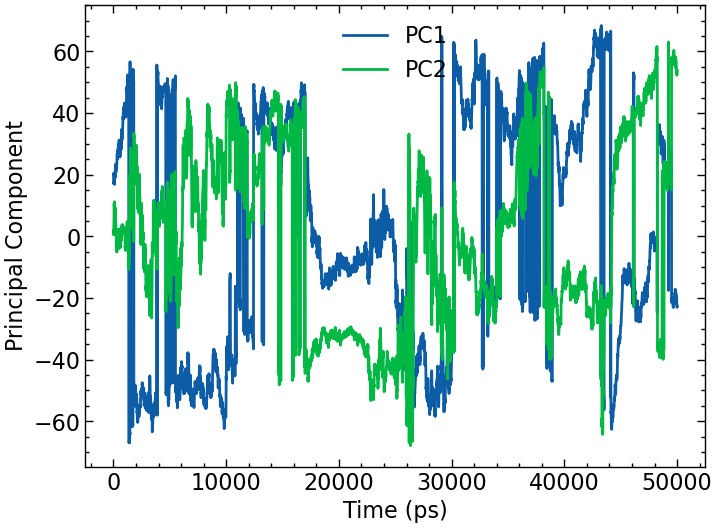

In [64]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])
plt.plot(t1, pc1_data, label='PC1')
plt.plot(t2, pc2_data, label='PC2')
plt.xlabel('Time (ps)')
plt.ylabel('Principal Component')
plt.legend()

For PCA with respect to energy, first

`paste prod_colpk_pyc_complex_pc1.xvg prod_colpk_pyc_complex_pc2.xvg | awk '{print $1, $2, $4}' > prod_colpk_pyc_complex_pc1pc2.xvg`

Then, use this PC1PC2.xvg file to generate an xpm file

`gmx sham -f prod_colpk_pyc_complex_pc1pc2.xvg -ls prod_colpk_pyc_complex_FES.xpm`

Then use the following `xpm2txt.py` script to convert the .xpm file into .dat file:


In [ ]:
#!/usr/bin/env python3

import sys

"""
Utility tool to convert xpm files generated by GROMACS to a 3-column text file.
"""

USAGE = "USAGE: xpm2txt.py -f <input xpm file> -o <output txt file> [-s]\n"
USAGE += "Options:\n"
USAGE += "\t-s\t(int)\tSorts the output by a given column"
USAGE += "\n"  # always keep this line

# Parse arguments
read_input, read_output, sort = False, False, False
xpm_file, out_file, column_sort = None, None, None
for arg in sys.argv[1:]:
    if read_input:
        read_input = False
        xpm_file = arg
    elif read_output:
        read_output = False
        out_file = arg
    elif sort:
        sort = False
        column_sort = int(arg)
    if arg.startswith("-"):
        if arg == "-f":
            read_input = True
            continue
        elif arg == "-o":
            read_output = True
            continue
        elif arg == "-s":
            sort = True
        else:
            print(USAGE)
            sys.stderr.write('ERROR: Option not recognized: %s\n' % arg)
            sys.exit(1)

if not xpm_file:
    print(USAGE)
    sys.stderr.write('ERROR: You forgot to provide an input file.\n')
    sys.exit(1)
if not out_file:
    out_file = "out.txt"

# Parse XPM file
with open(xpm_file) as xpm_handle:
    xpm_data = []
    x_axis, y_axis = [], []
    letter_to_value = {}
    for line in xpm_handle:
        if line.startswith("/* x-axis"):
            x_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith("/* y-axis"):
            y_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith('"') and x_axis and y_axis:  # Read data
            xpm_data.insert(0, line.strip().strip(',')[1:-1])

        if line.startswith('"') and len(line.split()) > 4:
            letter = line.split()[0][1:]
            value = float(line.split()[-2][1:-1])
            letter_to_value[letter] = value

# Match x/y/data
txt_values = []
for y_index, data_value in enumerate(xpm_data):
    y_value = y_axis[y_index]
    for x_index, x_value in enumerate(x_axis):
        txt_values.append([x_value, y_value, letter_to_value[data_value[x_index]]])

# Apply sorting if requested
if column_sort:
    try:
        txt_values.sort(key=lambda x: x[column_sort - 1])
    except IndexError:
        print(USAGE)
        sys.stderr.write('ERROR: Column not found (%s)\n' % (column_sort))
        sys.exit(1)

# Print to file
with open(out_file, 'w') as out_handle:
    for x, y, z in txt_values:
        out_handle.write("%3.5f\t%3.5f\t%3.5f\n" % (x, y, z))

Use this above-mentioned script as

`./xpm2txt.py -f prod_colpk_pyc_complex_FES.xpm -o prod_colpk_pyc_complex_FEL.dat`

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Read input data from a file
input_file = 'colpk_py/sys_prod/prod_colpk_pyc_complex_FEL.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC1 = data[:, 0]
PC2 = data[:, 1]
free_energy = data[:, 2]


# Function to read XVG file and extract data
def read_xvg(file_path):
    data = np.genfromtxt(file_path, skip_header=18)  # Adjust skip_header based on your XVG file format
    xpoints = data[:, 0]
    ypoints = data[:, 1]
    return xpoints, ypoints

# Replace these placeholders with your actual file paths
D1_path = 'colpk_py/sys_prod/prod_colpk_pyc_complex_eigenvalues.xvg'

# Read data from XVG files
time_D1, D1_data = read_xvg(D1_path)


/tmp/ipykernel_179786/4102706720.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=True, fontsize=25)


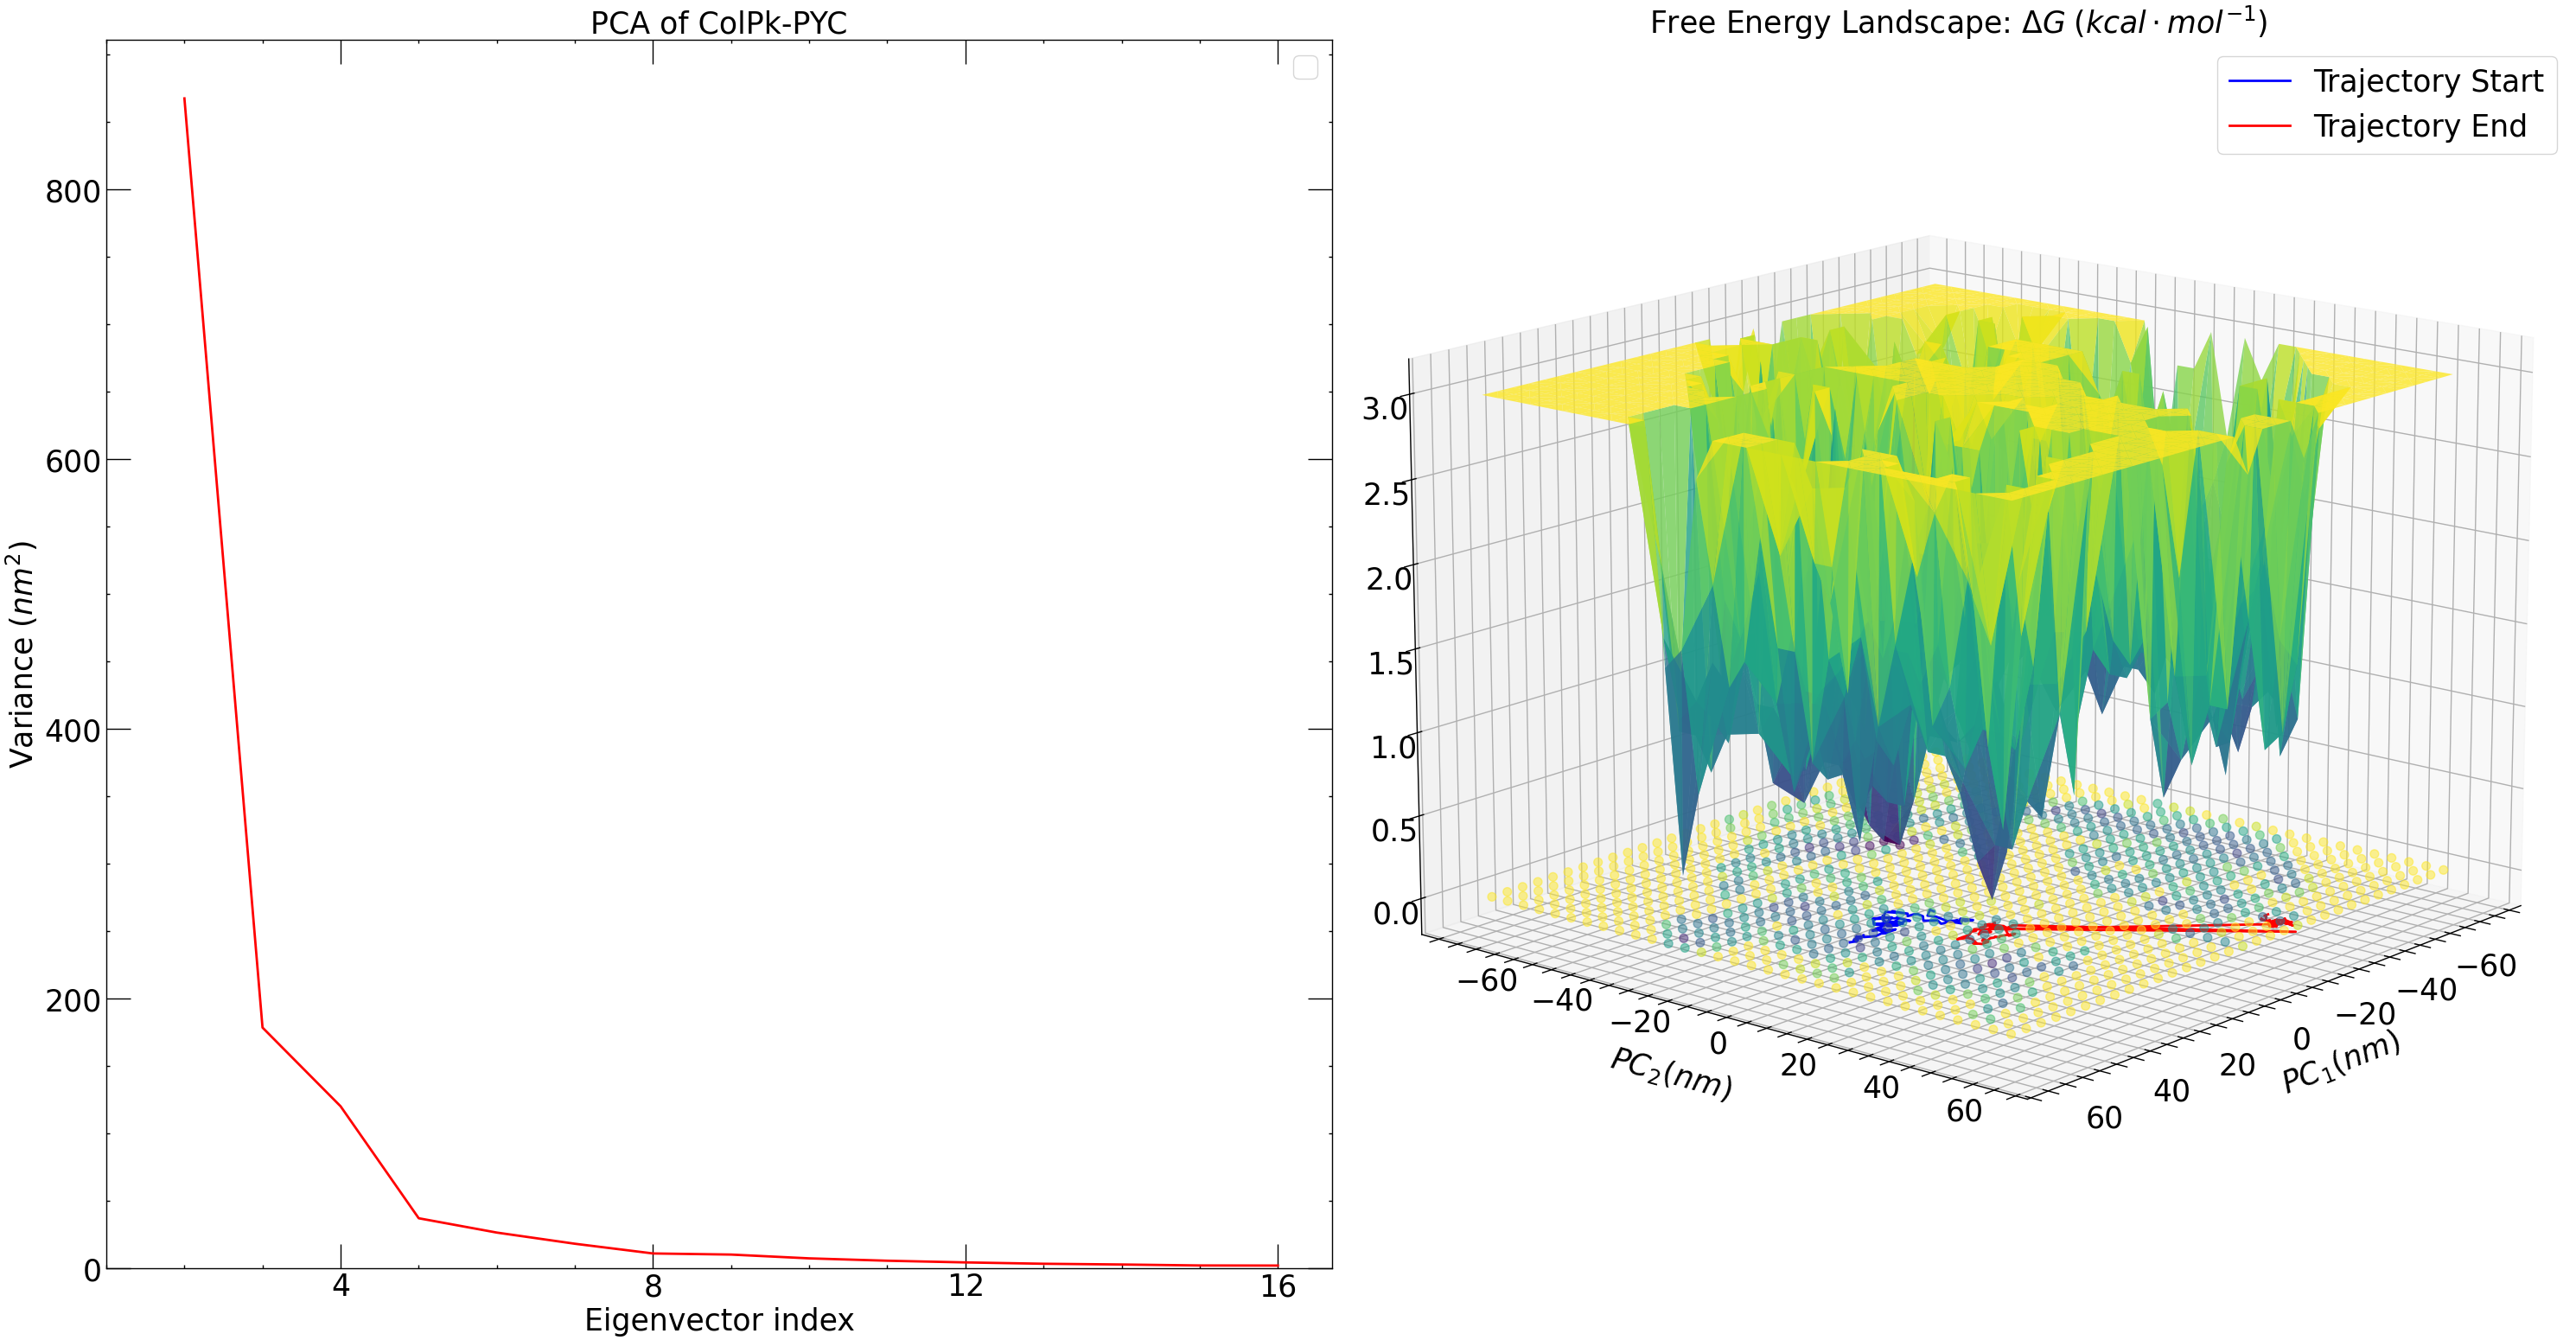

In [81]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scienceplots
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

import matplotlib.pyplot as plt

plt.style.use(['science','notebook'])

#########################################################################################
# Adjust this to pinpoint the delta G cross-section at the PC1 values you want to analyze 
pc1_values = np.array([2.82329, 3.52922])

# Adjust this to set the initial guess for the minima search
trial_minima = [0, -15]
#########################################################################################

# Create a figure with 3 panels
fig = plt.figure(tight_layout=True, figsize=(30, 30))

# Upper left panel: Eigenvalue cumulative sum plot
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(time_D1[0:15], D1_data[0:15], color='red')
ax1.set_xlim(1, )
ax1.set_ylim(0, )
ax1.set_xlabel('Eigenvector index')
ax1.set_ylabel(r'Variance $\left(nm^2\right)$')
ax1.set_title('PCA of ColPk-PYC')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.tick_params(axis='both', which='major')

# Upper right panel: 3D plot of the free energy
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.plot_trisurf(PC1, PC2, free_energy/4.184, cmap='viridis', alpha=0.8)
ax2.zaxis.set_rotate_label(False)  # disable automatic rotation
ax2.set_xlabel(r'$PC_1\left(nm\right)$', labelpad=25)
ax2.xaxis.set_tick_params(pad=10)
ax2.set_ylabel(r'$PC_2\left(nm\right)$', labelpad=20)
ax2.yaxis.set_tick_params(pad=0)
ax2.set_title(r'Free Energy Landscape: $\Delta G\; \left(kcal \cdot mol^{-1}\right)$')
ax2.scatter(PC1, PC2, c=free_energy/4.184, cmap='viridis', s=50, alpha=0.5)
ax2.plot(pc1_data[0:100], pc2_data[0:100], 0, color='blue', label='Trajectory Start')
ax2.plot(pc1_data[-100:-1], pc2_data[-100:-1], 0, color='red', label='Trajectory End')
ax2.view_init(elev=15, azim=40)
ax2.legend()

fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax2.set_position([0.55, 0.55, 0.8, 0.8])  # [left, bottom, width, height]

# Make all mark sizes bigger
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', length=20)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.xaxis.label.set_size(25)
    ax.yaxis.label.set_size(25)
    ax.title.set_size(25)
    ax.legend(frameon=True, fontsize=25)
    if hasattr(ax, 'zaxis'):
        ax.zaxis.label.set_size(25)
        ax.zaxis.set_tick_params(labelsize=25)

plt.savefig("pca_plots.png", dpi=600)
# Show the plot
plt.show()

### PCA Conclusion

The PCA reveals complex free energy landscape. The trajectory appears to start inside a free energy valley in the $PC_1-PC_2$ space, but then oscillates between that valley and an adjacent valley towards the end. Both valleys appear to be of equal avefage depth of $\Delta G\approx (3.0-1.0) = 2.0\; kcal\cdot mol^{-1}$. Thus, very little overall reduction in Free energy takes place, confirming the absense of any ligand-protein hydrogen bonds that would have led to large changes in free energy.


**However**, the lack of any clustering in the PCA density plots (shown on the 2D projection on the $PC_1-PC_2-$plane in the right panel) might also mean that the simulation needs to run for longer for the system to equilibrate in a particular valley.



Finally, I ran the following commands to project the trajectory to the PCA components and then visualize them.

`gmx anaeig -f prod_colpk_pyc_complex_compact_compact.xtc -s start.pdb -extr extreme_pc.pdb -first 1 -last 2 -n prod_colpk_pyc_complex_pca.ndx -nframes 30 -v prod_colpk_pyc_complex_eigenvectors.trr`

Then load the two pdbs of the projetions along each axis into pymol and made the following observations:


1. Along PC1, the protein seems to simply rotate as a rigid body
2. Along PC2, however, the tail beginning of the protein seems to 'whip about' a bit, suggesting a possible **conformational change** that might cause the shifts from one valley to another in the free energy landscape above.


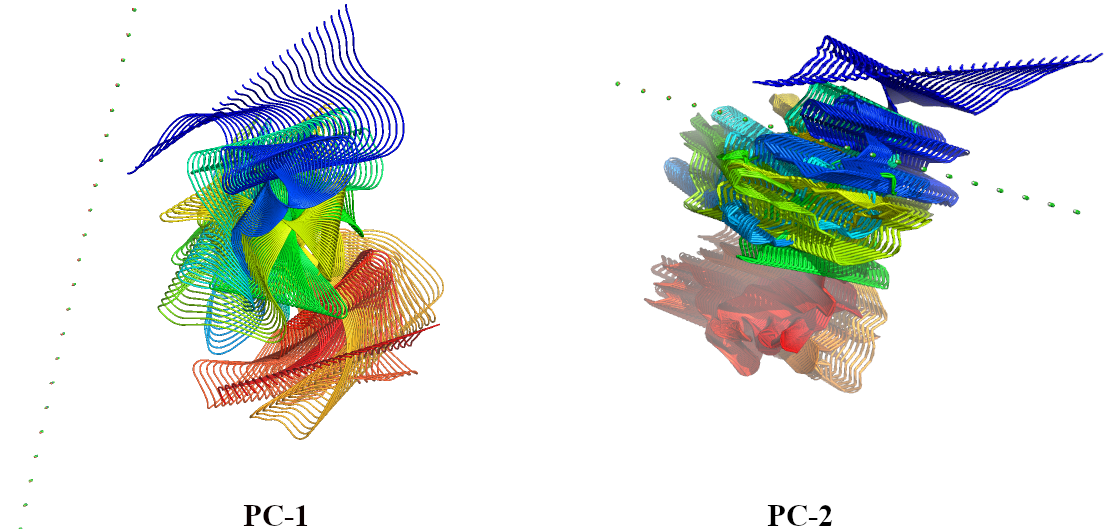

In [1]:
from IPython.display import Image
Image("pc1pc2.png")

Another problem here is that the ligand is very far from the protein. It was spat out of its docked pose during equilibration. Either this means that the ligand has no inhibitory effect on the protein, or something has gone wrong with the simulation.

One possibility is that a problem arose due to the fact that I was compelled to assign a charge to the `PYC` ligand during the generation of the AMBER topology using `acpype` after protonating the molecule in `openbabel`. if I did not do that, then `acpype` kept failing. 

We **should** rerun this simulation with **proper docking using** `AMDock` and the ligand properly protonated in `pymol` rather than `openbabel`, so that it doesn't pick up a charge.
